# Keras exercise

In this exercise you will be creating a Keras model by loading a data set, preprocessing input data, building a Sequential Keras model and compiling the model with a training configuration. Afterwards, you train your model on the training data and evaluate it on the test set. To finish this exercise, you will past the accuracy of your model to the Coursera grader.

This notebook is tested in IBM Watson Studio under python 3.6

## Data

For this exercise we will use the Reuters newswire dataset. This dataset consists of 11,228 newswires from the Reuters news agency. Each wire is encoded as a sequence of word indexes, just as in the IMDB data we encountered in lecture 5 of this series. Moreover, each wire is categorised into one of 46 topics, which will serve as our label. This dataset is available through the Keras API.

## Goal

We want to create a Multi-layer perceptron (MLP) using Keras which we can train to classify news items into the specified 46 topics.

## Instructions

We start by installing and importing everything we need for this exercise:

In [1]:
!pip install tensorflow==2.2.0rc0

     |████████████████████████████████| 515.9MB 69kB/s s eta 0:00:01��█████████████████████████▌  | 475.2MB 82.9MB/s eta 0:00:01
     |████████████████████████████████| 450kB 62.8MB/s eta 0:00:01  |████████████████                | 225kB 62.8MB/s eta 0:00:01
     |████████████████████████████████| 2.9MB 64.2MB/s eta 0:00:01
     |████████████████████████████████| 51kB 28.5MB/s eta 0:00:01
     |████████████████████████████████| 14.5MB 60.5MB/s eta 0:00:01
     |████████████████████████████████| 71kB 36.8MB/s eta 0:00:01
     |████████████████████████████████| 61kB 33.1MB/s eta 0:00:01
     |████████████████████████████████| 26.1MB 59.4MB/s eta 0:00:01          | 552kB 59.4MB/s eta 0:00:01     |██████████████                  | 11.4MB 59.4MB/s eta 0:00:01
     |████████████████████████████████| 3.9MB 62.7MB/s eta 0:00:01
     |████████████████████████████████| 92kB 36.6MB/s eta 0:00:01
     |████████████████████████████████| 163kB 57.1MB/s eta 0:00:01
     |█████████████████████████████

     |████████████████████████████████| 81kB 32.8MB/s eta 0:00:01
ERROR: autoai-libs 1.10.5 has requirement pandas>=0.24.2, but you'll have pandas 0.24.1 which is incompatible.
ERROR: tensorboard 2.1.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.16.1 which is incompatible.
ERROR: tensorboard 2.1.1 has requirement setuptools>=41.0.0, but you'll have setuptools 40.8.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.13.0
    Uninstalling tensorflow-estimator-1.13.0:
      Successfully uninstalled tensorflow-estimator-1.13.0
  Found existing installation: astunparse 1.6.2
    Uninstalling astunparse-1.6.2:
      Successfully uninstalled astunparse-1.6.2
  Found existing installation: numpy 1.15.4
    Uninstalling numpy-1.15.4:
      Successfully uninstalled numpy-1.15.4
  Found existing installation: h5py 2.9.0
    Uninstalling h5py-2.9.0:
      Successfully uninstalled h5py-2.9.0
  Found existing installation: Keras-Preprocessing 1.0.5
    Uninsta

In [90]:
import tensorflow as tf
if not tf.__version__ == '2.2.0-rc0':
    print(tf.__version__)
    raise ValueError('please upgrade to TensorFlow 2.2.0-rc0, or restart your Kernel (Kernel->Restart & Clear Output)')

IMPORTANT! => Please restart the kernel by clicking on "Kernel"->"Restart and Clear Outout" and wait until all output disapears. Then your changes are beeing picked up

As you can see, we use Keras' Sequential model with only two types of layers: Dense and Dropout. We also specify a random seed to make our results reproducible. Next, we load the Reuters data set:

In [113]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalMaxPool1D, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
seed = 1337
np.random.seed(seed)
from tensorflow.keras.datasets import reuters

max_words = 1000
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_words,
                                                         test_split=0.2,
                                                         seed=seed)
num_classes = np.max(y_train) + 1  # 46 topics

/opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [114]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

Note that we cap the maximum number of words in a news item to 1000 by specifying the *num_words* key word. Also, 20% of the data will be test data and we ensure reproducibility by setting our random seed.

Our training features are still simply sequences of indexes and we need to further preprocess them, so that we can plug them into a *Dense* layer. For this we use a *Tokenizer* from Keras' text preprocessing module. This tokenizer will take an index sequence and map it to a vector of length *max_words=1000*. Each of the 1000 vector positions corresponds to one of the words in our newswire corpus. The output of the tokenizer has a 1 at the i-th position of the vector, if the word corresponding to i is in the description of the newswire, and 0 otherwise. Even if this word appears multiple times, we still just put a 1 into our vector, i.e. our tokenizer is binary. We use this tokenizer to transform both train and test features:

In [115]:
t = set()
for x in x_train:
    for e in set(x):
        t.add(e)
vocab_size = len(t) + 1
del t

In [116]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=max_words)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')

## 1. Exercise part: label encoding

Use to_categorical, as we did in the lectures, to transform both *y_train* and *y_test* into one-hot encoded vectors of length *num_classes*:

In [117]:
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

## 2. Exercise part: model definition

Next, initialise a Keras *Sequential* model and add three layers to it:

    Layer: Add a *Dense* layer with in input_shape=(max_words,), 512 output units and "relu" activation.
    Layer: Add a *Dropout* layer with dropout rate of 50%.
    Layer: Add a *Dense* layer with num_classes output units and "softmax" activation.

In [67]:
model = Sequential()
model.add(Dense(512, input_shape=(max_words,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

## 3. Exercise part: model compilation

As the next step, we need to compile our Keras model with a training configuration. Compile your model with "categorical_crossentropy" as loss function, "adam" as optimizer and specify "accuracy" as evaluation metric. NOTE: In case you get an error regarding h5py, just restart the kernel and start from scratch

In [68]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               512512    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 46)                23598     
Total params: 536,110
Trainable params: 536,110
Non-trainable params: 0
_________________________________________________________________


## 4. Exercise part: model training and evaluation

Next, define the batch_size for training as 32 and train the model for 5 epochs on *x_train* and *y_train* by using the *fit* method of your model. Then calculate the score for your trained model by running *evaluate* on *x_test* and *y_test* with the same batch size as used in *fit*.

In [69]:
batch_size = 32
history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                    verbose=True, batch_size=batch_size, epochs=5)

Epoch 1/5
281/281 [==============================] - 4s 15ms/step - loss: 1.3873 - accuracy: 0.6850 - val_loss: 0.9858 - val_accuracy: 0.7796
Epoch 2/5
281/281 [==============================] - 4s 15ms/step - loss: 0.7661 - accuracy: 0.8183 - val_loss: 0.8497 - val_accuracy: 0.8005
Epoch 3/5
281/281 [==============================] - 4s 14ms/step - loss: 0.5386 - accuracy: 0.8722 - val_loss: 0.8321 - val_accuracy: 0.8059
Epoch 4/5
281/281 [==============================] - 4s 14ms/step - loss: 0.4251 - accuracy: 0.8948 - val_loss: 0.8166 - val_accuracy: 0.8063
Epoch 5/5
281/281 [==============================] - 4s 14ms/step - loss: 0.3443 - accuracy: 0.9124 - val_loss: 0.8516 - val_accuracy: 0.8037


If you have done everything as specified, in particular set the random seed as we did above, your test accuracy should be around 80% 

In [70]:
score_train = model.evaluate(x_train, y_train, verbose=False)
score_test = model.evaluate(x_test, y_test, verbose=False)

print(f'Train: loss = {np.round(score_train[0], 5)}, accuracy={np.round(score_train[1], 5)}')
print(f'Test: loss = {np.round(score_test[0], 5)}, accuracy={np.round(score_test[1], 5)}')

Train: loss = 0.197, accuracy=0.94756
Test: loss = 0.85159, accuracy=0.80365


In [71]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

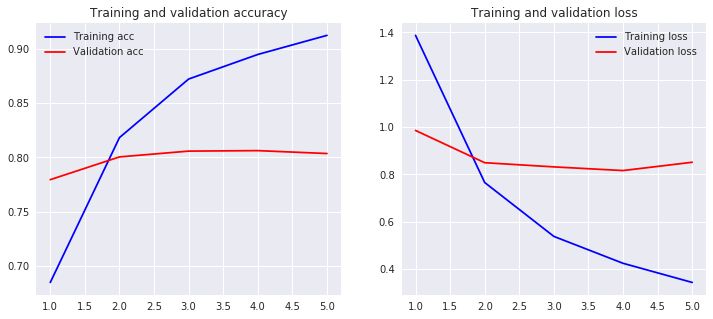

In [72]:
plot_history(history)

Congratulations, now it's time to submit your result to the Coursera grader by executing the following cells (Programming Assingment, Week2). 

We have to install a little library in order to submit to coursera


## Improoving

In [134]:
embedding_dim = 50

model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                   output_dim=embedding_dim, 
                   input_length=max_words))
model.add(GlobalMaxPool1D())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [135]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1000, 50)          49950     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 50)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               6528      
_________________________________________________________________
dense_29 (Dense)             (None, 46)                5934      
Total params: 62,412
Trainable params: 62,412
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 32
history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                    verbose=True, batch_size=batch_size, epochs=50)

Epoch 1/50
152/281 [===============>..............] - ETA: 4s - loss: 2.8316 - accuracy: 0.3485

In [ ]:
score_train = model.evaluate(x_train, y_train, verbose=False)
score_test = model.evaluate(x_test, y_test, verbose=False)

print(f'Train: loss = {np.round(score_train[0], 5)}, accuracy={np.round(score_train[1], 5)}')
print(f'Test: loss = {np.round(score_test[0], 5)}, accuracy={np.round(score_test[1], 5)}')

In [ ]:
plot_history(history)

In [73]:
!rm -f rklib.py
!wget https://raw.githubusercontent.com/IBM/coursera/master/rklib.py

--2020-07-30 14:43:44--  https://raw.githubusercontent.com/IBM/coursera/master/rklib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2540 (2.5K) [text/plain]
Saving to: ‘rklib.py’

100%[======================================>] 2,540       --.-K/s   in 0s      

2020-07-30 14:43:44 (37.6 MB/s) - ‘rklib.py’ saved [2540/2540]



Please provide your email address and obtain a submission token (secret) on the grader’s submission page in coursera, then execute the cell

In [74]:
from rklib import submit
import json

key = "XbAMqtjdEeepUgo7OOVwng"
part = "HCvcp"
email = "kriwohizha@gmail.com"
token = "iBpYPiH3OZhqCy1H"


submit(email, token, 'XbAMqtjdEeepUgo7OOVwng', part, [part], json.dumps(score_test[1]*100))

Submission successful, please check on the coursera grader page for the status
-------------------------
{"elements":[{"itemId":"ozVf2","id":"tE4j0qhMEeecqgpT6QjMdA~ozVf2~KSYoZ9JzEeq5pA5-jI22NQ","courseId":"tE4j0qhMEeecqgpT6QjMdA"}],"paging":{},"linked":{}}
-------------------------
